In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor as gpr 
from sklearn.gaussian_process.kernels import ConstantKernel,DotProduct, RBF, RationalQuadratic, ExpSineSquared, Matern, Exponentiation

Using TensorFlow backend.


In [2]:
df = pd.read_excel('./Gibbs energy inference.xlsx')
df_Fe_C = pd.read_excel('./Fe-C system.xlsx')
df_Fe_Cr = pd.read_excel('./Fe-Cr system.xlsx')
df_Fe_C_Cr = pd.read_excel('./Fe-C-Cr system.xlsx')

In [3]:
df_Fe_C_1=df_Fe_C.reindex(columns=['Wt-% Cr','Wt-% C', 'T/K', 'Gibbs_energy/J/mol'], fill_value=0)

In [4]:
df_Fe_Cr_1=df_Fe_Cr.reindex(columns=['Wt-% Cr','Wt-% C', 'T/K', 'Gibbs_energy/J/mol'], fill_value=0)

In [5]:
df=pd.concat([df_Fe_C_1,df_Fe_Cr_1,df_Fe_C_Cr]).reset_index(drop=True)

In [6]:
X=df[['Wt-% Cr','Wt-% C', 'T/K']]
y=df['Gibbs_energy/J/mol']

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [8]:
X_train = X.loc[:95].rename(columns={0:'Wt-% Cr',1:'Wt-% C',2:'T/K'})
y_train = y.loc[:95].rename(columns={0:'Gibbs_energy/J/mol'})
X_test = X.loc[96:].rename(columns={0:'Wt-% Cr',1:'Wt-% C',2:'T/K'})
y_test = y.loc[96:].rename(columns={0:'Gibbs_energy/J/mol'})

In [9]:
df_Fe_C_Cr.describe()

,Wt-% Cr,Wt-% C,T/K,Gibbs_energy/J/mol
count,16.000000,16.000000,16.000000,16.00000
mean,0.174063,0.022538,1358.375000,-69875.98125
std,0.127531,0.025835,118.718083,9320.01549
min,0.020000,0.001000,1100.000000,-82362.00000
25%,0.087500,0.005900,1273.000000,-76828.85000
50%,0.150000,0.015500,1373.000000,-70681.55000
75%,0.261250,0.024000,1473.000000,-63702.37500
max,0.500000,0.100000,1500.000000,-50434.60000


In [10]:
y_test.describe()

count       16.00000
mean    -69875.98125
std       9320.01549
min     -82362.00000
25%     -76828.85000
50%     -70681.55000
75%     -63702.37500
max     -50434.60000
dtype: float64

In [11]:
Gaussian= gpr(alpha = 0.0001,n_restarts_optimizer=5,normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=42)
#kernel=k,alpha = 0.0001,n_restarts_optimizer=5,normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=42)
Gaussian.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.0001, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=5, normalize_y='True',
                         optimizer='fmin_l_bfgs_b', random_state=42)

In [12]:
#y_prediction=Gaussian.predict(Test[['Wt-% Cr','Wt-% C', 'T/K']])

In [13]:
#y_prediction

In [14]:
#np.array(Test['Gibbs_energy/J/mol'])

In [15]:
def Mean_absolute_percentage_error(ture_value, prediction_value):
    return np.mean(np.abs((prediction_value- ture_value)/ture_value))*100

In [16]:
#Mean_absolute_percentage_error(Test['Gibbs_energy/J/mol'].values,y_prediction)

In [17]:
#Gaussian.score(Test[['Wt-% Cr','Wt-% C', 'T/K']],Test['Gibbs_energy/J/mol'])

In [18]:
from pandas.core.frame import DataFrame
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb

from sklearn.naive_bayes import MultinomialNB

In [19]:
string= ['RandomForest','MultipleLayerPerceptron',
        'DecisionTree','KNeighbor(Arithmetic mean)','KNeighbor(weighed mean)','Linear','rbf_SVR',
         'linear_SVR','RidgeCV','KernelRidge',
         'Gaussian_DotProduct']
data_total=pd.DataFrame()
data_R2=pd.DataFrame()
data_MAPE=pd.DataFrame()
data_MSE=pd.DataFrame()
model_list = [RandomForestRegressor(),
             MLPRegressor(activation='identity', solver='adam', alpha=0.0001, max_iter=10000),
             DecisionTreeRegressor(),
             KNeighborsRegressor(weights='uniform'),KNeighborsRegressor(weights='distance'), 
             LinearRegression(),SVR(kernel='rbf',C=1),SVR(kernel='linear'),
             RidgeCV(),
             KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
             gpr(kernel=1**2 * DotProduct(sigma_0=1),n_restarts_optimizer=5,
                      normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=0)]
for index, model in enumerate (model_list):
    R2=[]
    MAPE=[]
    MSE=[]
    MAE=[]
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    R2.append(model.score(X_test, y_test))
    MAPE.append(Mean_absolute_percentage_error(y_test, y_predict))
    MSE.append(mean_squared_error(y_test, y_predict))
    MAE.append(mean_absolute_error(y_test, y_predict))
    a=np.vstack((np.array(R2),np.array(MAPE),np.array(MSE),np.array(MAE)))#所有的array并列起来
    data1 = pd.DataFrame(a, index=['%s R2'% string[index],'%s MAPE'% string[index], '%s MSE' %string[index],
                                   '%s  MAE'% string[index]], 
                         columns=['Gibbs_energy/J/mol'])  
    data2 = pd.DataFrame(np.matrix(R2), index=['%s R2'% string[index]],
                                   columns=['Gibbs_energy/J/mol']) 
    data3= pd.DataFrame(np.matrix(MAPE), index=['%s MAPE'% string[index]],
                                   columns=['Error in %'])
    data4= pd.DataFrame(np.matrix(MSE), index=['%s MSE'% string[index]],
                                   columns=['Gibbs_energy/J/mol'])
    data_total=pd.concat([data_total,data1])#生成纵轴上的并集，索引会自动生成新的一
    data_R2=pd.concat([data_R2,data2])
    data_MAPE=pd.concat([data_MAPE,data3])
    data_MSE=pd.concat([data_MSE,data4])

pd.set_option('display.max_columns', None)#显示pandas完整数据
pd.set_option('display.max_rows', None)
data_total

/home/pascal/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pascal/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/pascal/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/pascal/.local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.75921860e+13, 5.

,Gibbs_energy/J/mol
RandomForest R2,9.299176e-01
RandomForest MAPE,2.899882e+00
RandomForest MSE,5.707074e+06
RandomForest MAE,1.929148e+03
MultipleLayerPerceptron R2,-1.825505e+01
MultipleLayerPerceptron MAPE,5.469881e+01
MultipleLayerPerceptron MSE,1.568012e+09
MultipleLayerPerceptron MAE,3.839438e+04
DecisionTree R2,8.755285e-01
DecisionTree MAPE,3.957428e+00


In [20]:
data_R2

,Gibbs_energy/J/mol
RandomForest R2,0.929918
MultipleLayerPerceptron R2,-18.255053
DecisionTree R2,0.875528
KNeighbor(Arithmetic mean) R2,0.900914
KNeighbor(weighed mean) R2,0.906561
Linear R2,0.919448
rbf_SVR R2,-0.123590
linear_SVR R2,-0.123358
RidgeCV R2,0.985863
KernelRidge R2,0.980383


In [21]:
data_MSE

,Gibbs_energy/J/mol
RandomForest MSE,5.707074e+06
MultipleLayerPerceptron MSE,1.568012e+09
DecisionTree MSE,1.013619e+07
KNeighbor(Arithmetic mean) MSE,8.068942e+06
KNeighbor(weighed mean) MSE,7.609105e+06
Linear MSE,6.559658e+06
rbf_SVR MSE,9.149820e+07
linear_SVR MSE,9.147932e+07
RidgeCV MSE,1.151268e+06
KernelRidge MSE,1.597496e+06


In [22]:
data_MAPE

,Error in %
RandomForest MAPE,2.899882
MultipleLayerPerceptron MAPE,54.698815
DecisionTree MAPE,3.957428
KNeighbor(Arithmetic mean) MAPE,3.345279
KNeighbor(weighed mean) MAPE,3.142914
Linear MAPE,2.782933
rbf_SVR MAPE,11.737815
linear_SVR MAPE,11.736561
RidgeCV MAPE,1.354966
KernelRidge MAPE,1.250699


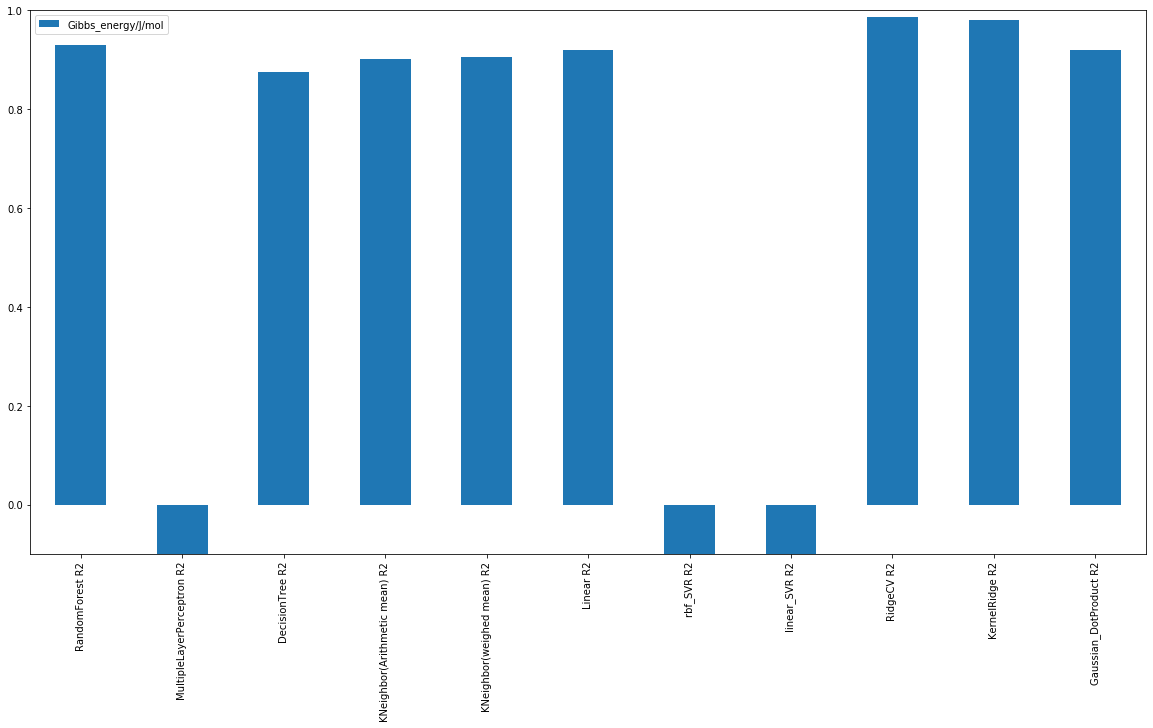

In [23]:
data_R2.plot.bar(figsize=(20, 10))
plt.ylim(-0.1,1)
plt.savefig('./ R2 of Different Algorithm.png',format='png')

In [24]:
data_MAPE

,Error in %
RandomForest MAPE,2.899882
MultipleLayerPerceptron MAPE,54.698815
DecisionTree MAPE,3.957428
KNeighbor(Arithmetic mean) MAPE,3.345279
KNeighbor(weighed mean) MAPE,3.142914
Linear MAPE,2.782933
rbf_SVR MAPE,11.737815
linear_SVR MAPE,11.736561
RidgeCV MAPE,1.354966
KernelRidge MAPE,1.250699


In [25]:
#pd.set_option('mpl_style','default')
data_MAPE['Gibbs_energy/J/mol'].plot(kind='barh',figsize=(10, 10))
plt.savefig('./ MAPE of Different Algorithm2.png',format='png')

KeyError: 'Gibbs_energy/J/mol'

In [ ]:
data_MAPE.plot.bar(figsize=(20, 7))
plt.savefig('./ MAPE of Different Algorithm1.png',format='png')

In [ ]:
data_MAPE.plot(kind='barh',stacked=True,figsize=(15, 10))
plt.xlabel(u"MAPE Value")# plots an axis lable
plt.ylabel(u"Algorithm") 
plt.title(u"MAPE of Different Algorithm")
plt.savefig('./ MAPE of Different Algorithm.png',format='png')